# LSTM을 활용한 주가 예측 모델

LSTM (Long Short Term Memory)은 RNN의 단점을 보완하여 장/단기 기억을 가능하게 설계한 신경망의 구조를 말함. 주로 시계열 처리나, 자연어 처리에 사용됨.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings  
import os  

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

## 데이터 (FinanceDataReader)

FinanceDataReader란?


In [2]:
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 3.2 MB/s 


In [3]:
import FinanceDataReader as fdr

In [4]:
# 현대차(005380) / (1998-04-13 ~ 현재)
Hyundai = fdr.DataReader('005380')

In [5]:
# 받아오는 데이터은 모두 'DataFrame'형식임



### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

In [6]:
# 주가데이터 가져오기

In [7]:
# 현대차 주식코드: 005380
STOCK_CODE = '005380'

In [8]:
stock = fdr.DataReader(STOCK_CODE)

In [9]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-04-15,13359,13359,12758,13192,41280,NaN
1998-04-16,13894,13894,12691,12891,88700,-0.022817
1998-04-17,13025,13025,12357,12357,82390,-0.041424
1998-04-18,12624,13025,12357,12424,49880,0.005422
1998-04-20,12491,12624,12157,12357,34010,-0.005393


In [10]:
stock.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-06-10,181500,185000,180500,184500,571131,0.010959
2022-06-13,180000,181500,173000,175000,1193167,-0.051491
2022-06-14,171500,172500,169000,171500,1122467,-0.020000
2022-06-15,173500,179000,171500,174000,995832,0.014577
2022-06-16,177000,177500,174000,174500,390590,0.002874


In [11]:
stock.index

DatetimeIndex(['1998-04-15', '1998-04-16', '1998-04-17', '1998-04-18',
               '1998-04-20', '1998-04-21', '1998-04-22', '1998-04-23',
               '1998-04-24', '1998-04-25',
               ...
               '2022-06-02', '2022-06-03', '2022-06-07', '2022-06-08',
               '2022-06-09', '2022-06-10', '2022-06-13', '2022-06-14',
               '2022-06-15', '2022-06-16'],
              dtype='datetime64[ns]', name='Date', length=6000, freq=None)

index가 `DatetimeIndex`로 지정되어 있음

`DatetimeIndex`로 정의되어 있다면, 연도, 월, 일을 쪼갤 수 있고, **월별, 연도별 피벗데이터**를 만들때 활용이 가능

In [12]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

In [13]:
stock.head()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
1998-04-15,13359,13359,12758,13192,41280,NaN,1998,4,15
1998-04-16,13894,13894,12691,12891,88700,-0.022817,1998,4,16
1998-04-17,13025,13025,12357,12357,82390,-0.041424,1998,4,17
1998-04-18,12624,13025,12357,12424,49880,0.005422,1998,4,18
1998-04-20,12491,12624,12157,12357,34010,-0.005393,1998,4,20


## 시각화

Text(0, 0.5, 'price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


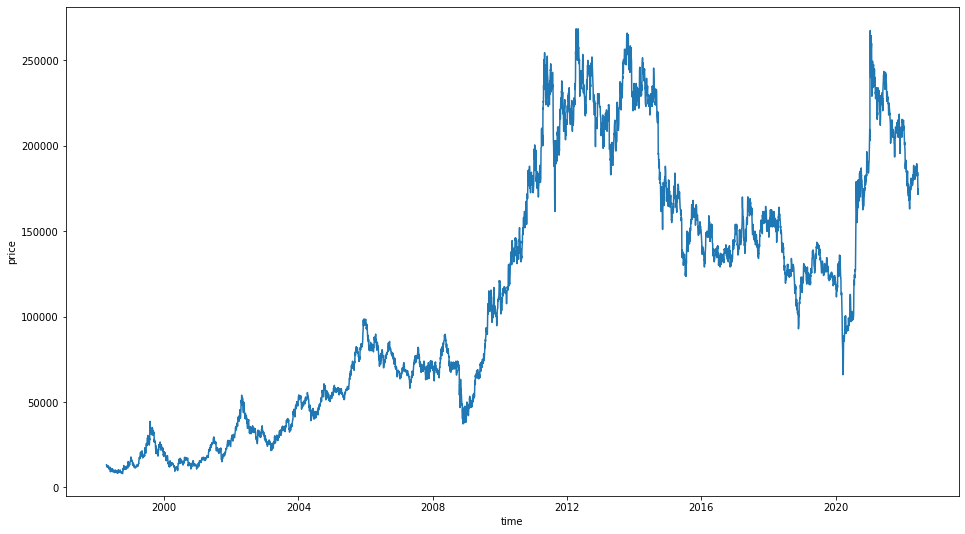

In [14]:
plt.figure(figsize=(16, 9)) 
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


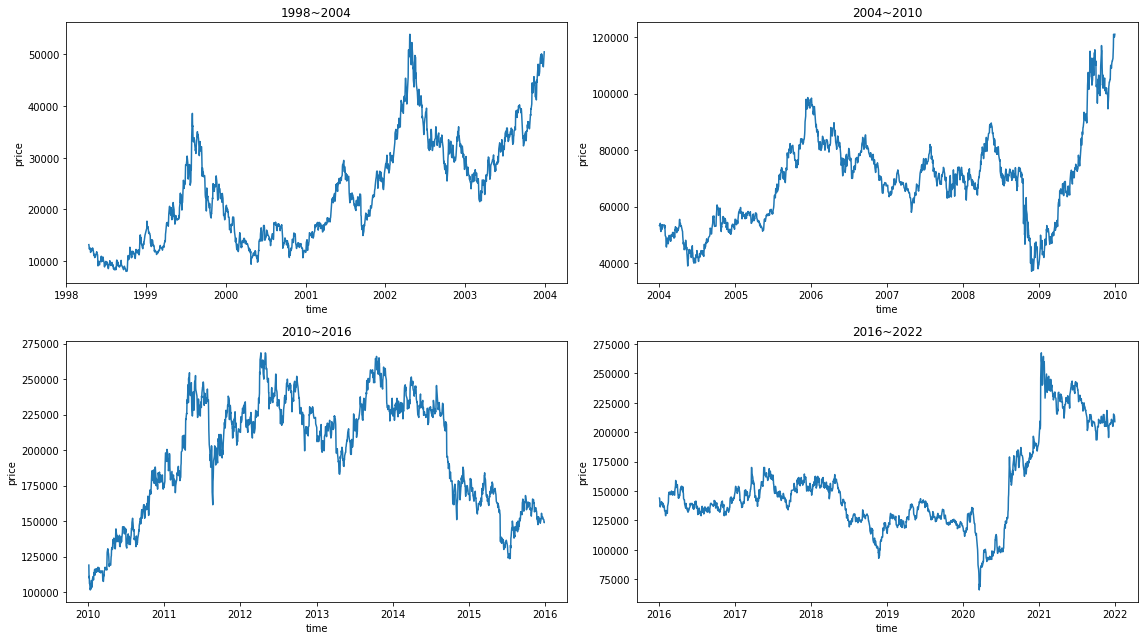

In [16]:
time_steps = [['1998', '2004'], 
              ['2004', '2010'], 
              ['2010', '2016'], 
              ['2016', '2022']]

fig, axes = plt.subplots(2, 2) 
fig.set_size_inches(16, 9)

for i in range(4):
    ax = axes[i//2, i%2] 
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

## 데이터 전처리

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
scaled = scaler.fit_transform(stock[scale_cols])
scaled   

array([[0.01988078, 0.01848436, 0.01873852, 0.01982931, 0.00138127],
       [0.02191603, 0.02038941, 0.01847891, 0.01867372, 0.0031525 ],
       [0.01861017, 0.01729504, 0.01718473, 0.0166236 , 0.00291681],
       ...,
       [0.62148159, 0.58516124, 0.62414464, 0.62760056, 0.04176569],
       [0.62909   , 0.60830675, 0.63383163, 0.63719848, 0.03703563],
       [0.64240471, 0.60296547, 0.64351863, 0.63911807, 0.01442868]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성

In [18]:
df = pd.DataFrame(scaled, columns=scale_cols)

## train / test 분할

In [19]:
from sklearn.model_selection import train_test_split  

In [20]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [21]:
x_train.shape, y_train.shape

((4800, 4), (4800,))

In [22]:
x_test.shape, y_test.shape

((1200, 4), (1200,))

In [23]:
x_train

,Open,High,Low,Volume
0,0.019881,0.018484,0.018739,0.001381
1,0.021916,0.020389,0.018479,0.003153
2,0.018610,0.017295,0.017185,0.002917
3,0.017085,0.017295,0.017185,0.001703
4,0.016579,0.015867,0.016410,0.001110
...,...,...,...,...
4795,0.535887,0.501481,0.531149,0.017855
4796,0.532083,0.497920,0.536962,0.011158
4797,0.532083,0.497920,0.529212,0.020697
4798,0.520670,0.496140,0.529212,0.028568


In [24]:
x_test

,Open,High,Low,Volume
4800,0.532083,0.499701,0.529212,0.020465
4801,0.526376,0.505042,0.536962,0.031865
4802,0.537789,0.503262,0.529212,0.032395
4803,0.520670,0.494360,0.529212,0.015374
4804,0.526376,0.497920,0.533087,0.017104
...,...,...,...,...
5995,0.659524,0.629672,0.668705,0.021172
5996,0.653817,0.617209,0.639644,0.044406
5997,0.621482,0.585161,0.624145,0.041766
5998,0.629090,0.608307,0.633832,0.037036


## Tensorflow Dataset을 활용한 시퀀스 데이터셋 구성

In [25]:
import tensorflow as tf

https://teddylee777.github.io/tensorflow/dataset-batch-window

In [26]:
def windowed_dataset(series, window_size, batch_size, shuffle): # Dataset 구성 함수 / # https://teddylee777.github.io/tensorflow/dataset-batch-window
    series = tf.expand_dims(series, axis=-1)      # 1차적으로 차원증가 후 텐서슬라이스에 매개변수로 전달 / 텐서슬라이스란? 객체 감지 및 ML 애플리케이션에서 작업할 때 텐서의 슬라이싱이 필요한 경우 사용
    ds = tf.data.Dataset.from_tensor_slices(series) # ex) 7일 + 1일 = 8일의 데이터 생성 (7일은 학습데이터, 1일은 정답데이터로 사용됨), drop_remainder 파라미터는 예측할 학습데이터가 7개가 안되면 삭제해서 진행
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True) 
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle: 
        ds = ds.shuffle(1000) # shuffle을 이용해서 무작위로 섞음
    ds = ds.map(lambda w: (w[:-1], w[-1])) # 마지막으로 batch_size 만큼 다시한번 매핑진행(1 : 1 대응)
    return ds.batch(batch_size).prefetch(1) # 알고리즘이 한 batch로 작업하는 동안 이 데이터셋이 동시에 다음 batch를 준비 = 훈련속도 상승의 효과를 줌

Hyperparameter를 정의합니다. http://blog.skby.net/%ED%95%98%EC%9D%B4%ED%8D%BC%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0-hyperparameter/

In [27]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [28]:
# train_data는 학습용 데이터셋, test_data는 검증용 데이터셋
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [29]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있음
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


## 모델

In [30]:
from tensorflow.keras.models import Sequential  # 시퀀스 모델은 각 레이어에 정확히 하나의 입력 텐서와 하나의 출력 텐서가 있는 일반 레이어 스택에 적합
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda # (Dense) 뉴런의 입력과 출력을 연결해주는 역할 # (Conv1D) 레이어 입력과 컨볼루션 커널을 만들어 텐서 출력을 생성 # (Lambda) 익명 함수
from tensorflow.keras.losses import Huber # 특이치 에 강한 선형 회귀 모델
from tensorflow.keras.optimizers import Adam # 알고리즘을 구현하는 최적화 프로그램
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # 조기 종료 및 , 체크포인트 생성함수 


model = Sequential([ # 순차적 모델
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [31]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [32]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춤
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터 생성
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [33]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    149/Unknown - 14s 8ms/step - loss: 5.9607e-04 - mse: 0.0012
Epoch 1: val_loss improved from inf to 0.00052, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 17s 23ms/step - loss: 5.9533e-04 - mse: 0.0012 - val_loss: 5.1653e-04 - val_mse: 0.0010
Epoch 2/50
147/150 [============================>.] - ETA: 0s - loss: 2.3162e-04 - mse: 4.6324e-04
Epoch 2: val_loss improved from 0.00052 to 0.00042, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 2s 12ms/step - loss: 2.3277e-04 - mse: 4.6554e-04 - val_loss: 4.2022e-04 - val_mse: 8.4045e-04
Epoch 3/50
150/150 [==============================] - ETA: 0s - loss: 2.0923e-04 - mse: 4.1846e-04
Epoch 3: val_loss improved from 0.00042 to 0.00039, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 1s 8ms/step - loss: 2.0923e-04 - mse: 4.1846e-04 - val_loss: 3.8738e-04 - val_mse: 7.7477e-04
Epoch 4/50
143/150 [===========================>..] - E

저장한 ModelCheckpoint 를 로드합니다.

In [35]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.

In [36]:
pred = model.predict(test_data)

In [37]:
pred.shape

(1180, 1)

## 예측 데이터 시각화

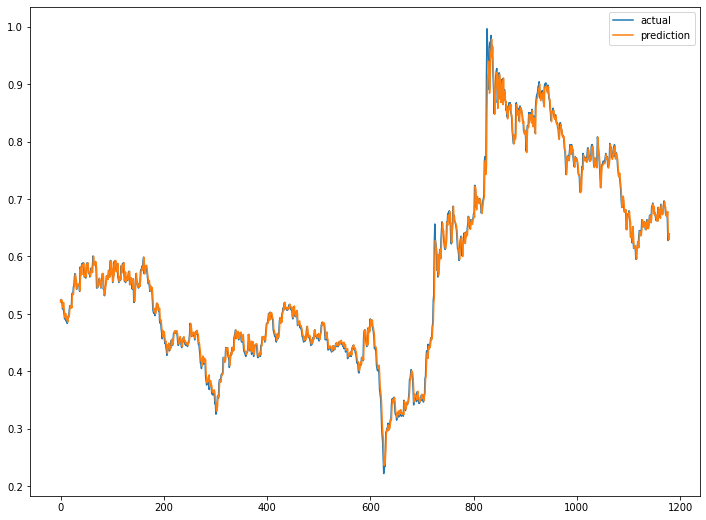

In [38]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()